# Quick start

Let's set up a simple emulator for scattering of 14.1 MeV protons on $^{27}$Al, using the [Koning-Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw) optical potential for the proton-nucleus interaction.

In [1]:
import rose
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# set up kinematics
from rose.koning_delaroche import KDGlobal, Projectile

# for 27-Al
A = 27
Z = 13

# lab bombarding energy
Elab = 14.1  # MeV

# get kinematics and default KD params
omp = rose.koning_delaroche.KDGlobal(Projectile.proton)
(mu, Ecom, k, eta, R_C), parameters = omp.get_params(A, Z, Elab)

In [3]:
# take train and test parameter samples from a box bounded 50% aboce and below the default values
scale = 0.5  
bounds = np.array(
    [
        parameters -  np.fabs(scale * parameters),
        parameters +  np.fabs(scale * parameters),
    ]
).T

In [4]:
from rose.training import sample_params_LHC

n_test = 20
n_train = 80

# sample 80/20 train/test split from +/-50% around the default params
train = sample_params_LHC(n_train, parameters, 0.5, seed=13)
test = sample_params_LHC(n_test, parameters, 0.5, seed=721)

In [5]:
# instantiate the interaction
interactions = rose.InteractionEIMSpace(
    rose.koning_delaroche.KD_simple,
    len(parameters),
    mu,
    Ecom,
    is_complex=True,
    spin_orbit_potential=rose.koning_delaroche.KD_simple_so,
    training_info=bounds,
    Z_1=1,
    Z_2=13,
    R_C=R_C,
)

In [6]:
# set up and train emulator using sensible defaults
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    train,
    n_basis=10, # we will just choose 10 out of a hat for now, more on this later
    angles=np.linspace(np.pi/181, np.pi, 180),
    l_cutoff_rel=1e-6,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [01:47<00:00,  5.12s/it]


Now we have a trained emulator! Let's compare observables between the emulator and the high-fidelity solver using our test set of sampled parameters.

In [10]:
%%time
# use %%timeit to get a more percise timing  - but may take a while to run!

# run high-fidelity solver
HIFI_xs = []
for sample in tqdm(test):
    HIFI_xs.append( emulator.exact_xs(sample) )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:55<00:00, 17.78s/it]

CPU times: user 5min 55s, sys: 345 ms, total: 5min 55s
Wall time: 5min 55s


In [14]:
%%time
# use %%timeit to get a more percise timing  - this one will be fast either way!

# run emulator
emu_xs = []
for sample in tqdm(test):
    emu_xs.append( emulator.emulate_xs(sample))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 77.09it/s]

CPU times: user 553 ms, sys: 1 s, total: 1.55 s
Wall time: 262 ms


Now let's plot the results!

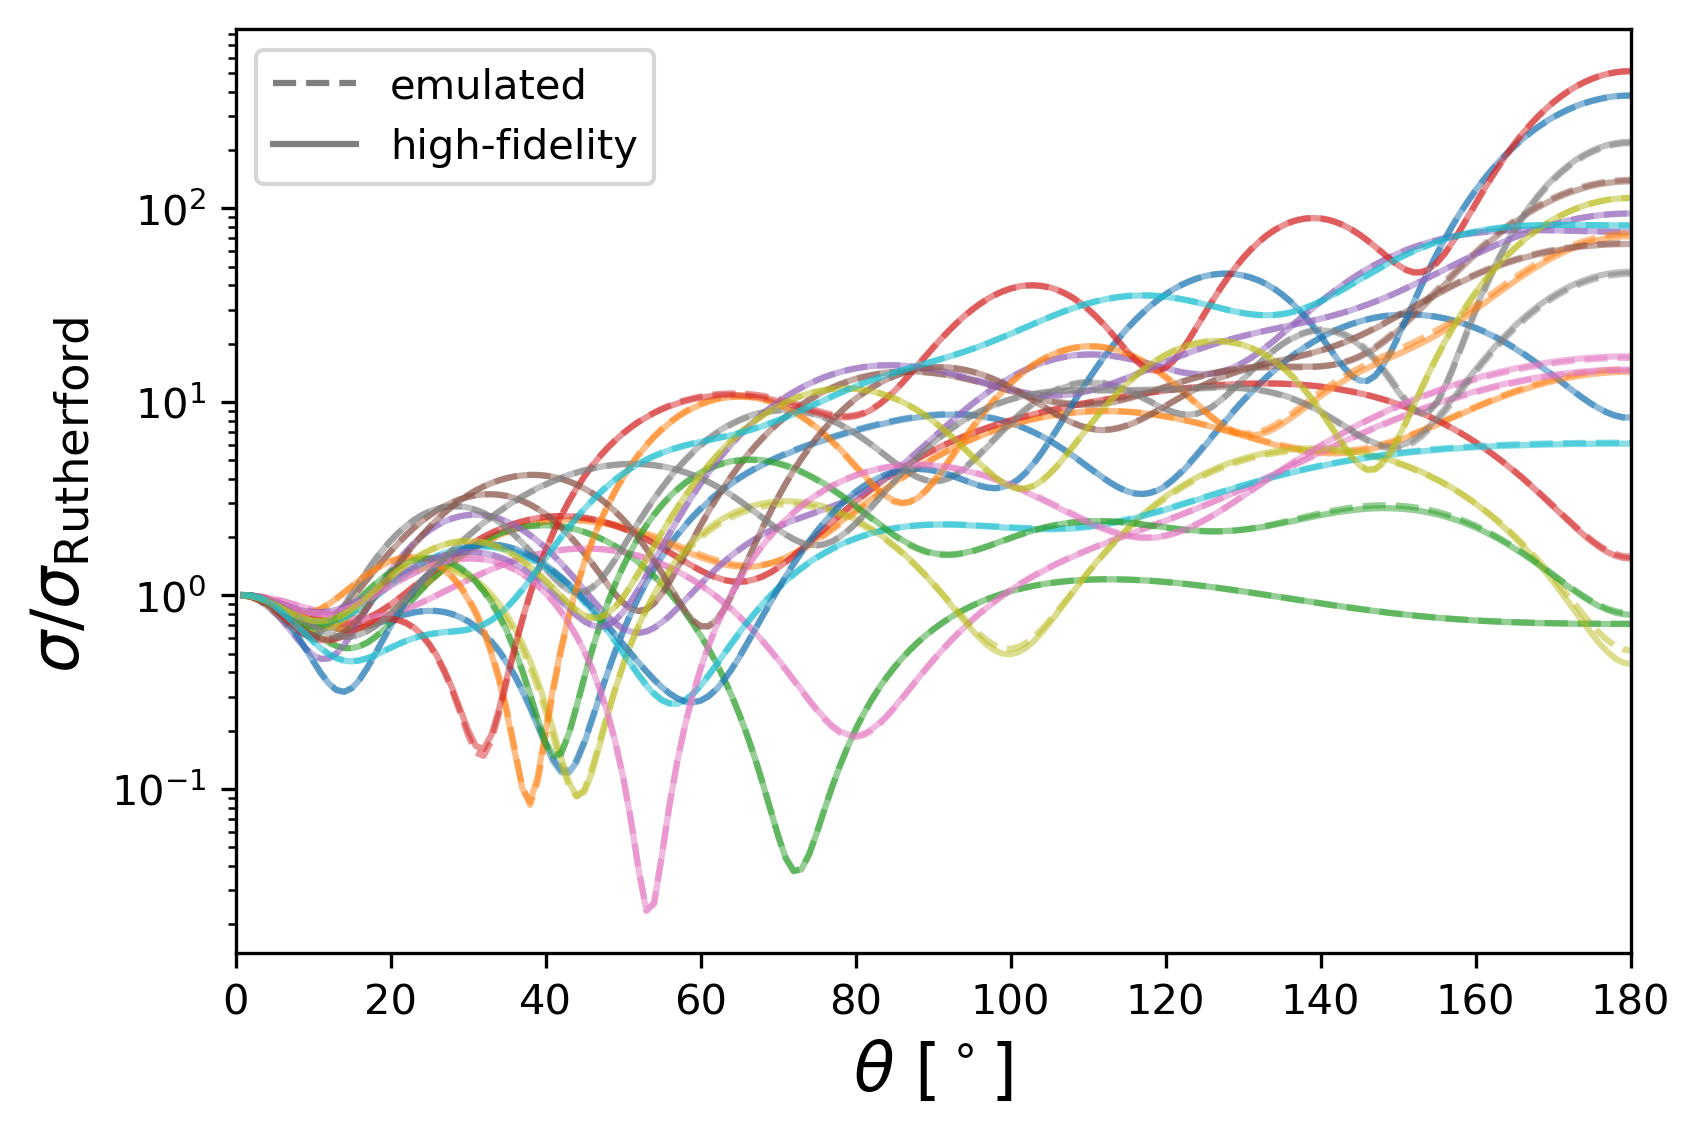

In [15]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180 / (np.pi)
    
    # HIFI
    y_exact = HIFI_xs[i].dsdo
    
    # emulated
    y_emu = emu_xs[i].dsdo
    
    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_yscale("log")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=16)
plt.ylabel(r"$\frac{d \sigma}{d\Omega}$ [mb/Sr]", fontsize=16)

plt.ylabel(r"$\sigma / \sigma_{\rm{Rutherford}}$ ", fontsize=16)
plt.show()

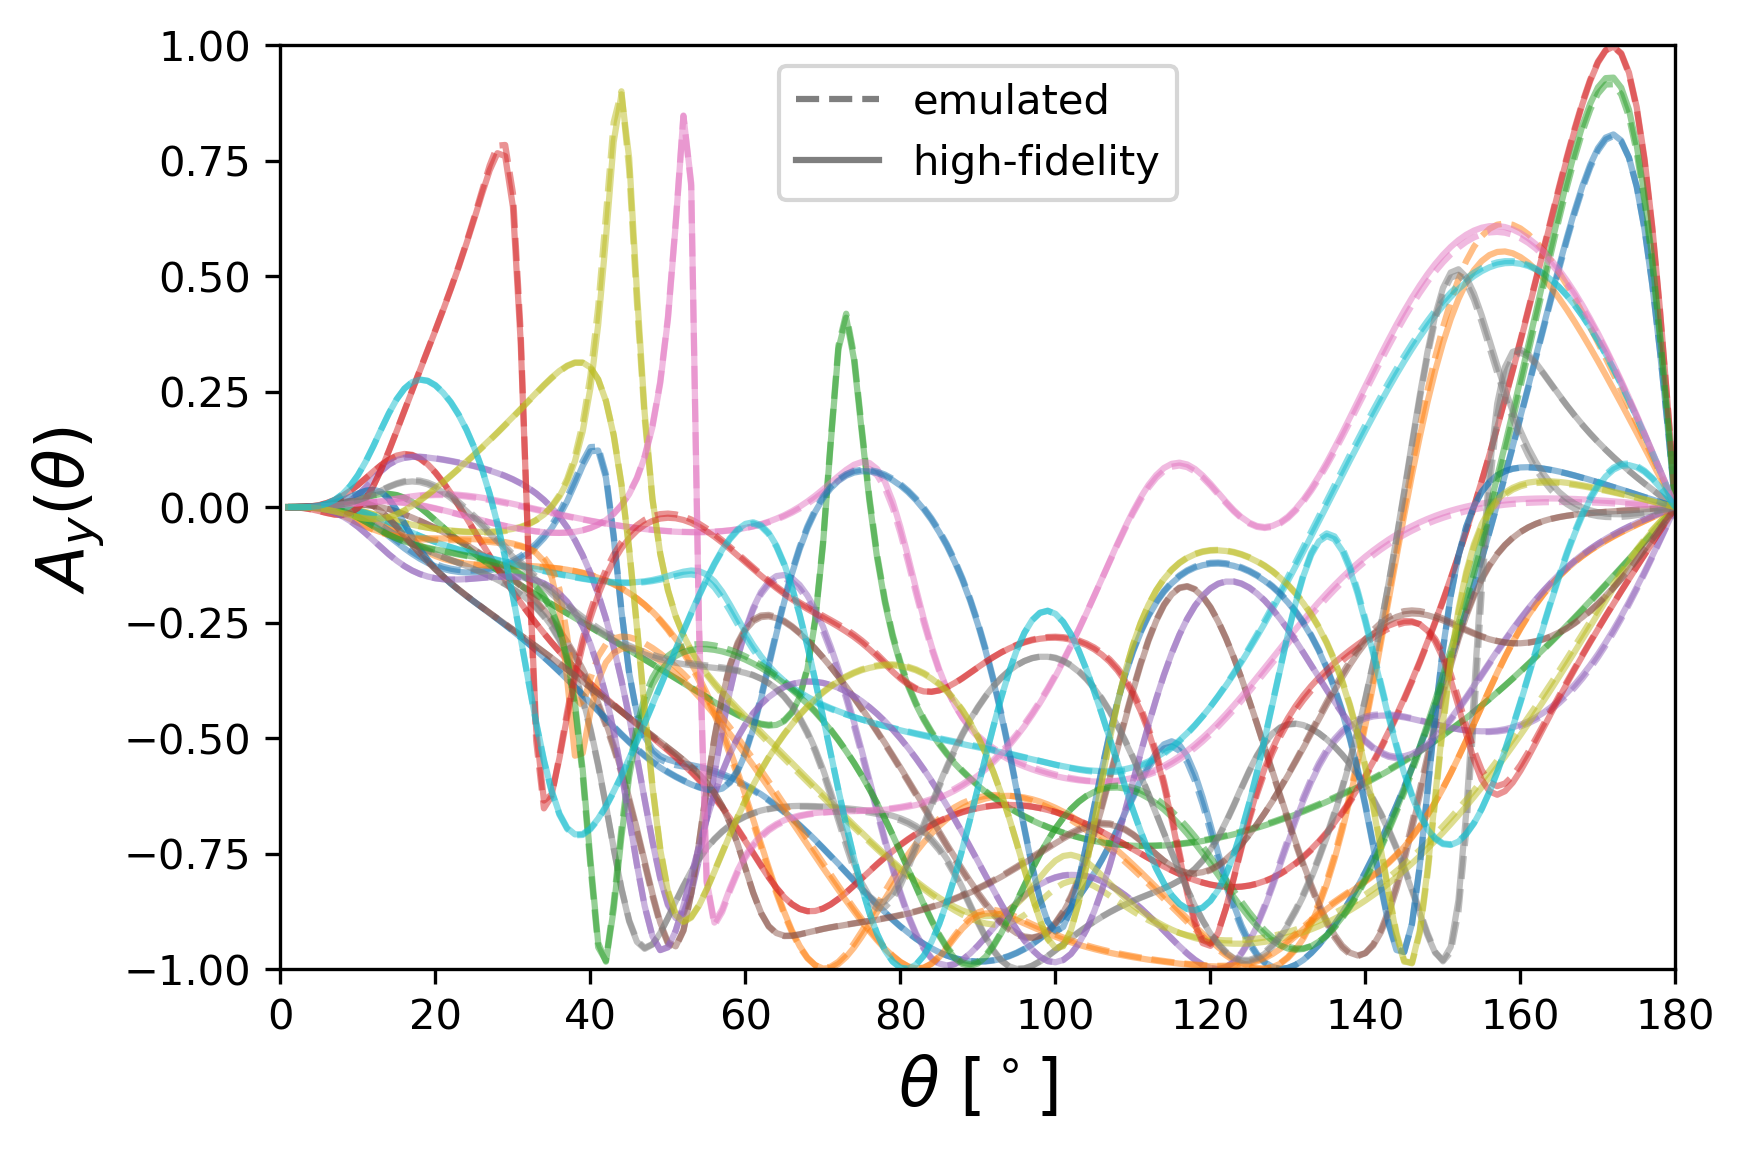

In [16]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
fig.patch.set_facecolor("white")

for i, sample in enumerate(test):
    x = emulator.angles * 180/(np.pi)
    
    # HIFI
    y_exact = HIFI_xs[i].Ay 
    
    # emulated
    y_emu = emu_xs[i].Ay

    p = ax.plot(x, y_emu, "--", alpha=0.5)
    ax.plot(x, y_exact, color=p[0].get_color(), alpha=0.5)

legend_styles = [
    Line2D([0], [0], color="k", linestyle="--", alpha=0.5),
    Line2D([0], [0], color="k", alpha=0.5),
]
ax.legend(legend_styles, ["emulated", "high-fidelity"])
ax.set_ylim([-1,1])
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]", fontsize=16)
plt.ylabel(r"$A_y(\theta)$ ", fontsize=16)
plt.show()

Isn't that nice! The following series of tutorials will walk through how to choose the the optimal hyper-parameters (like the basis size), and demonstrate linking to `surmise` for fast Bayesian uncertainty quantification!